/home/ubuntu/brain-decoding/utils/plot_metrics.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(metrics_path)


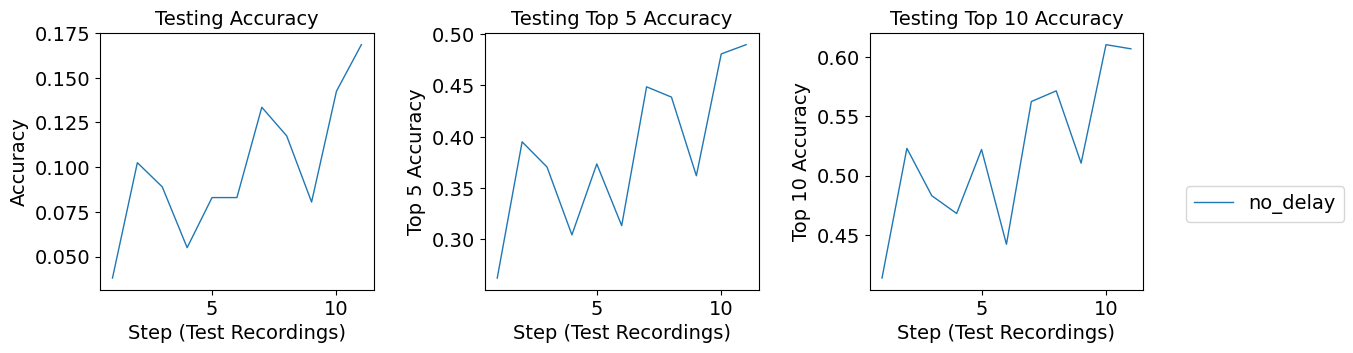

In [8]:
from utils.plot_metrics import display_metrics, display_best_performance_barchart

# Example usage:
studies = {
    "no_delay": "/home/ubuntu/brain-decoding/saves/phase1/ablation/delay/0_0/epoch_11",
    # "No scaling": "saves/phase1/ablation/scaling/Dec19_no_scaling/epoch_15",
    # "Robust": "saves/phase1/ablation/scaling/Dec19_robust_only/epoch_16",
    # "Standard": "saves/phase1/ablation/scaling/Dec19_standard_only/epoch_21",
    # "both": "saves/phase1/objective/Dec18_CLIP_MSE_384/epoch_20",
}

# Using a moving average window of 5 to smooth the curves
display_metrics(
    studies,
    train_metrics=[],  # "loss",
    test_metrics=["accuracy", "top_5_accuracy", "top_10_accuracy"],
    smooth_window=1,
    test_subset="unseen_subject",
)

/home/ubuntu/brain-decoding/utils/plot_metrics.py:306: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(metrics_path)


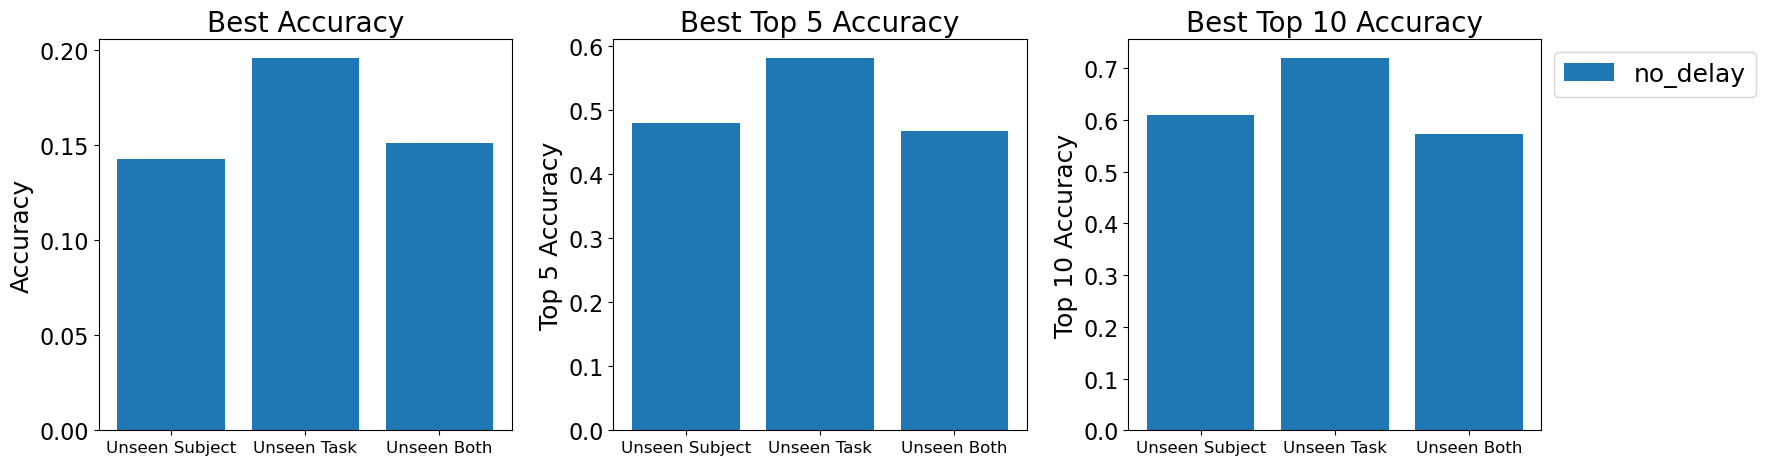

In [10]:
display_best_performance_barchart(
    studies,
    test_metrics=["accuracy", "top_5_accuracy", "top_10_accuracy"],
    test_subsets=["unseen_subject", "unseen_task", "unseen_both"],
)

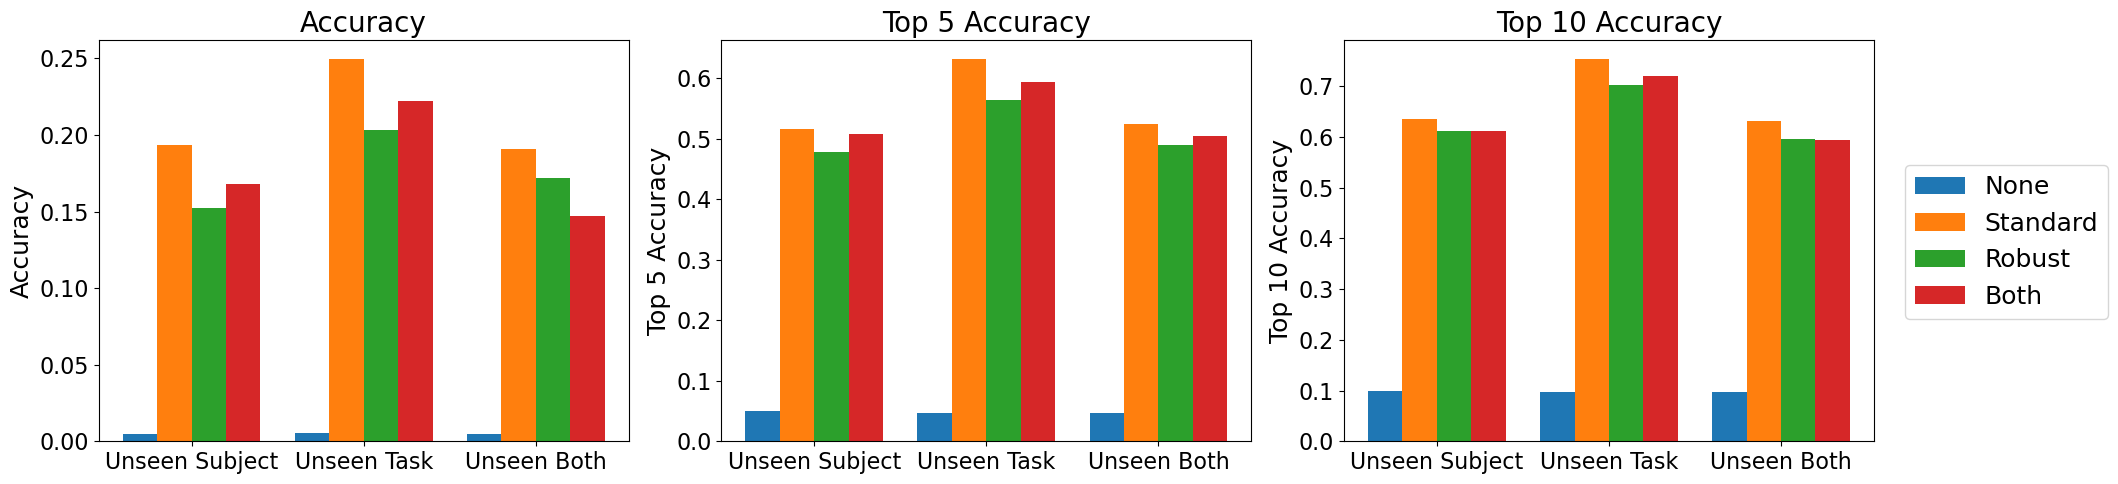

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Data provided:

# Both scaling:
both_unseen_subject = {
    "Accuracy": 0.1677,
    "Top 5 Accuracy": 0.5074,
    "Top 10 Accuracy": 0.6115,
}
both_unseen_task = {
    "Accuracy": 0.2222,
    "Top 5 Accuracy": 0.5937,
    "Top 10 Accuracy": 0.7192,
}
both_unseen_both = {
    "Accuracy": 0.1470,
    "Top 5 Accuracy": 0.5042,
    "Top 10 Accuracy": 0.5927,
}

# None scaling:
none_unseen_subject = {
    "Accuracy": 0.0049,
    "Top 5 Accuracy": 0.0494,
    "Top 10 Accuracy": 0.0988,
}
none_unseen_task = {
    "Accuracy": 0.0051,
    "Top 5 Accuracy": 0.0470,
    "Top 10 Accuracy": 0.0975,
}
none_unseen_both = {
    "Accuracy": 0.0050,
    "Top 5 Accuracy": 0.0472,
    "Top 10 Accuracy": 0.0969,
}

# Standard only:
std_unseen_subject = {
    "Accuracy": 0.1936,
    "Top 5 Accuracy": 0.5166,
    "Top 10 Accuracy": 0.6345,
}
std_unseen_task = {
    "Accuracy": 0.2493,
    "Top 5 Accuracy": 0.6310,
    "Top 10 Accuracy": 0.7524,
}
std_unseen_both = {
    "Accuracy": 0.1909,
    "Top 5 Accuracy": 0.5236,
    "Top 10 Accuracy": 0.6312,
}

# Robust only:
rob_unseen_subject = {
    "Accuracy": 0.1523,
    "Top 5 Accuracy": 0.4774,
    "Top 10 Accuracy": 0.6115,
}
rob_unseen_task = {
    "Accuracy": 0.2033,
    "Top 5 Accuracy": 0.5646,
    "Top 10 Accuracy": 0.7015,
}
rob_unseen_both = {
    "Accuracy": 0.1718,
    "Top 5 Accuracy": 0.4894,
    "Top 10 Accuracy": 0.5949,
}

# Group data by scaling method:
data_none = {
    "unseen_subject": none_unseen_subject,
    "unseen_task": none_unseen_task,
    "unseen_both": none_unseen_both,
}

data_std = {
    "unseen_subject": std_unseen_subject,
    "unseen_task": std_unseen_task,
    "unseen_both": std_unseen_both,
}

data_rob = {
    "unseen_subject": rob_unseen_subject,
    "unseen_task": rob_unseen_task,
    "unseen_both": rob_unseen_both,
}

data_both = {
    "unseen_subject": both_unseen_subject,
    "unseen_task": both_unseen_task,
    "unseen_both": both_unseen_both,
}

# We will plot the following metrics
metrics = ["Accuracy", "Top 5 Accuracy", "Top 10 Accuracy"]
# Test subsets
test_subsets = ["unseen_subject", "unseen_task", "unseen_both"]
# Scaling methods
scaling_methods = ["None", "Standard", "Robust", "Both"]
scaling_data = [data_none, data_std, data_rob, data_both]

# Create figure and subplots, one per metric
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5))
if len(metrics) == 1:
    axes = [axes]

import matplotlib as mpl


mpl.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 20,
        "axes.labelsize": 18,
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        "legend.fontsize": 18,
    }
)

mpl.rcParams.update()

# Positions for bars
x = np.arange(len(test_subsets))
bar_width = 0.2

for i, metric in enumerate(metrics):
    ax = axes[i]
    for j, (label, d) in enumerate(zip(scaling_methods, scaling_data)):
        # Extract values for this metric across subsets
        values = [d[subset][metric] for subset in test_subsets]
        offset = (j - 1.5) * bar_width  # to group them side by side
        ax.bar(x + offset, values, width=bar_width, label=label)

    ax.set_title(metric)
    ax.set_xticks(x)
    formatted_labels = [s.replace("_", " ").title() for s in test_subsets]
    ax.set_xticklabels(formatted_labels)
    ax.set_ylabel(metric)

# Create a single legend on the right side
fig.legend(scaling_methods, loc="center left", bbox_to_anchor=(0.95, 0.5))

plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave space on the right for the legend
plt.show()